<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.13.1].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=False)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=False)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [10]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self, name='cnn', xdim=[1, 28, 28],
                 # 아래와 같이 cdims, hdims 등을 편하게 수정할 수 있게 만들어주는 것이 이후 model tuning에 매우 큰 이점
                 ksize=3, cdims=[32, 64],hdims=[1024, 128], ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass, self).__init__()
        self.name = name
        self.xdim = xdim   # input dimensions
        self.ksize = ksize # kernel size
        self.cdims = cdims # channel dimensions
        self.hdims = hdims # hidden layer dimensions
        self.ydim = ydim   # output dimensions
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(
                    # FILL IN HERE
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1, 1),
                    padding=self.ksize//2
                )) # convlution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(
                # FILL IN HERE
                prev_hdim, hdim, bias=True
            ))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            # type(layer)를 소문자로 변환 + index를 뒤에 붙여서 이름을 지음(e.g., conv2d_00, linear_09, etc.)
            # layer_name을 따로 따로 설정해주면 이후 디버깅 과정에서 매우 큰 이점
            layer_name = "%s_%02d"%(type(layer).__name__.lower(), l_idx)
            # layer_name: 파이토치는 name scope가 따로 없어서 텐서플로우와 다르게 변수명 지정이 거의 불가하지만,
            # nn.Sequential에서는 아래 add_module 메서드를 통해서 layer_name을 따로 지정해줄 수 있음
            self.net.add_module(layer_name, layer)
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self, x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn', xdim=[1, 28, 28], ksize=3, cdims=[32, 64], # 28*28 -> 14*14*32 -> 7*7*64
#     hdims=[256, 128], ydim=10).to(device) # parameter 개수 85만 개
    hdims=[32], ydim=10).to(device) # parameter 개수 12만 개
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)
print ("Done.")

Done.


### Check Parameters

In [11]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.155 -0.336  0.232 -0.289  0.348]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[-0.095 -0.156  0.119  0.001  0.061]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.047  0.022  0.004  0.015 -0.013]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[ 0.162  0.071  0.232 -0.159 -0.012]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [13]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3, 1, 28, 28) # batch가 2개
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.060, 0.698, 0.583,  ..., 0.845, 0.749, 0.136],
          [0.462, 0.696, 0.550,  ..., 0.060, 0.503, 0.247],
          [0.349, 0.015, 0.479,  ..., 0.855, 0.017, 0.284],
          ...,
          [0.185, 0.078, 0.456,  ..., 0.860, 0.025, 0.834],
          [0.052, 0.865, 0.180,  ..., 0.298, 0.202, 0.935],
          [0.672, 0.807, 0.447,  ..., 0.701, 0.382, 0.670]]],


        [[[0.238, 0.337, 0.682,  ..., 0.956, 0.037, 0.711],
          [0.965, 0.901, 0.395,  ..., 0.341, 0.254, 0.259],
          [0.696, 0.673, 0.942,  ..., 0.743, 0.147, 0.634],
          ...,
          [0.609, 0.453, 0.657,  ..., 0.968, 0.489, 0.152],
          [0.938, 0.837, 0.224,  ..., 0.893, 0.644, 0.937],
          [0.510, 0.472, 0.749,  ..., 0.266, 0.613, 0.685]]],


        [[[0.868, 0.715, 0.745,  ..., 0.912, 0.691, 0.037],
          [0.365, 0.858, 0.224,  ..., 0.922, 0.637, 0.195],
          [0.650, 0.065, 0.630,  ..., 0.992, 0.400, 0.208],
          ...,
          [0.773, 0.388, 0.289,  ...,

### Evaluation Function

In [14]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [16]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
# training을 아직 하지 않았으니 10개 label 중 random하게 정답을 맞추는 확률이 출력 -> 약 10% 내외
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.091] test_accr:[0.099].


### Train

In [17]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode, 굉장히 중요함, BatchNorm2d와 같은 경우 training / inference phase에서 완전 다르게 동작하기 때문
EPOCHS, print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1, 1, 28, 28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()         # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()              # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.588] train_accr:[0.953] test_accr:[0.954].
epoch:[1] loss:[0.184] train_accr:[0.974] test_accr:[0.974].
epoch:[2] loss:[0.130] train_accr:[0.982] test_accr:[0.980].
epoch:[3] loss:[0.106] train_accr:[0.984] test_accr:[0.982].
epoch:[4] loss:[0.088] train_accr:[0.986] test_accr:[0.985].
epoch:[5] loss:[0.078] train_accr:[0.988] test_accr:[0.985].
epoch:[6] loss:[0.071] train_accr:[0.990] test_accr:[0.986].
epoch:[7] loss:[0.065] train_accr:[0.991] test_accr:[0.988].
epoch:[8] loss:[0.061] train_accr:[0.992] test_accr:[0.988].
epoch:[9] loss:[0.057] train_accr:[0.991] test_accr:[0.988].
Done


### Test

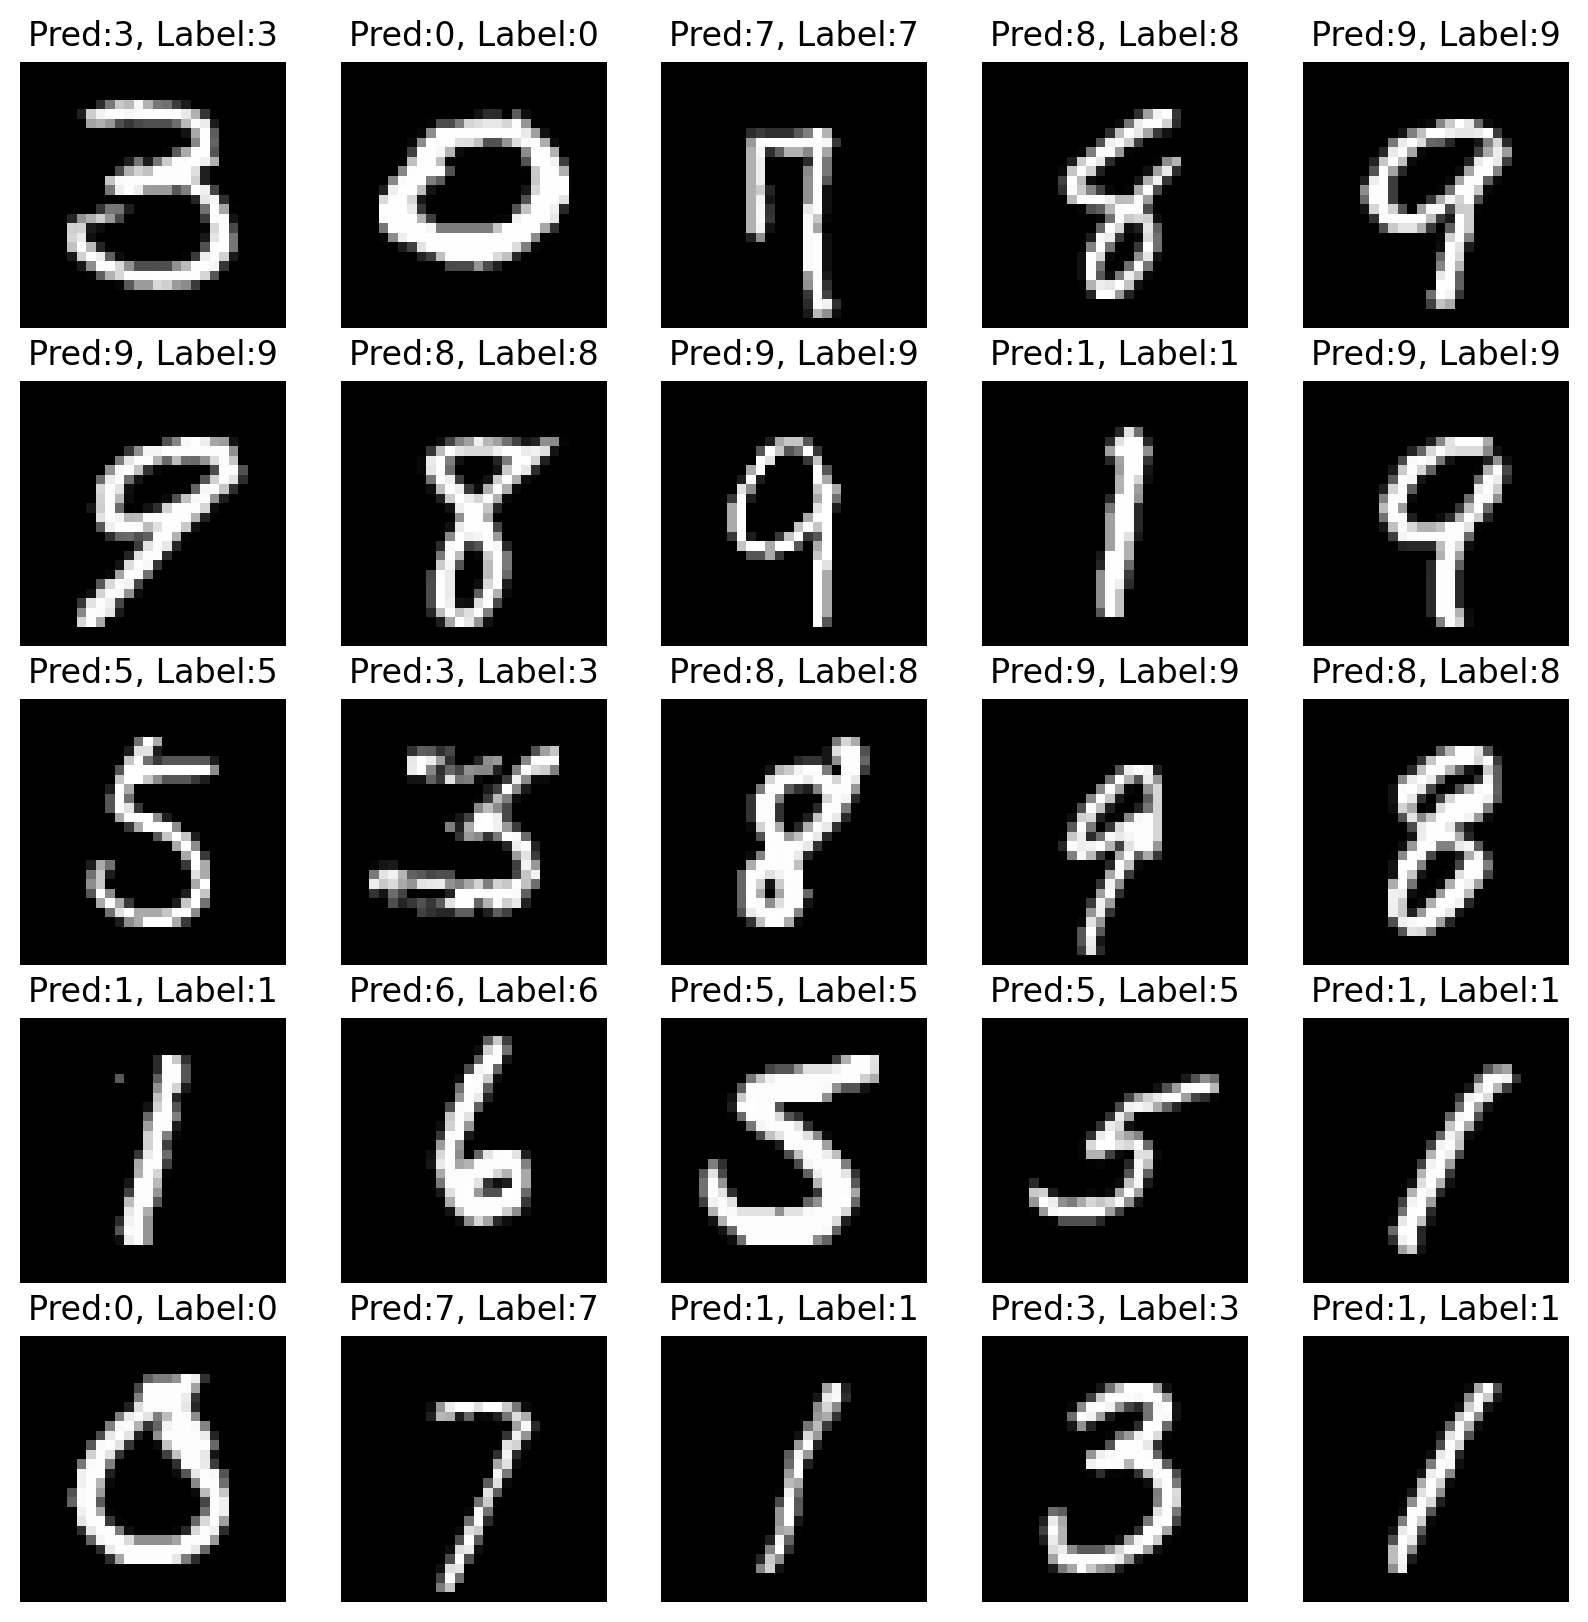

Done


In [18]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

